![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_UcFQAjh.max-800x600.png)

![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_1_kxflIxg.max-800x600.png)


![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_2_EnQyi4S.max-800x600.png)    


![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_3_ddZedfW.max-800x600.png)

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
print("슝=3")

슝=3


In [4]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


행의 크기가 50, 열의 크기가 512인 행렬을 그려봅시다. 이를테면, 최대 문장의 길이가 50이고 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양이 이와 같을 것입니다.

Q.위의 문장처럼 행의 크기가 50, 열의 크기가 512인 행렬을 만드는 코드를 완성하여 입력 벡터 모양을 시각화하세요.
(추가 : 아래 퀴즈를 풀면서 작성한 코드를 변경해보세요.)

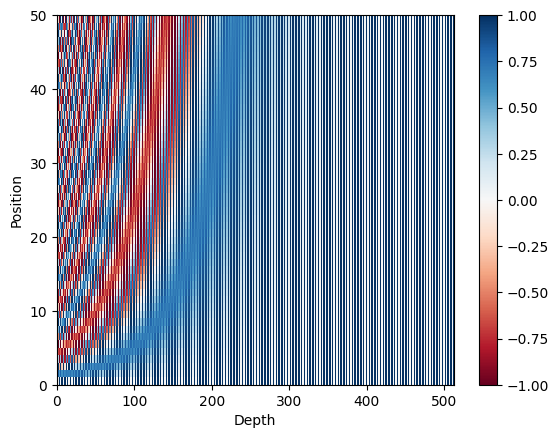

In [5]:
# Positional Encoding 객체 생성 (예: 50개 위치, 512 차원)
sample_pos_encoding = PositionalEncoding(50, 512)

# 시각화
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Q. 임베딩 벡터의 차원이 256이고 최대 문장의 길이가 30인 텍스트를 입력으로 하는 트랜스포머를 구현한다고 하였을 때, 적절한 포지셔널 인코딩 행렬의 크기를 추측해보고 위에 구현한 포지셔널 인코딩 레이어를 사용해 표현해 보세요.

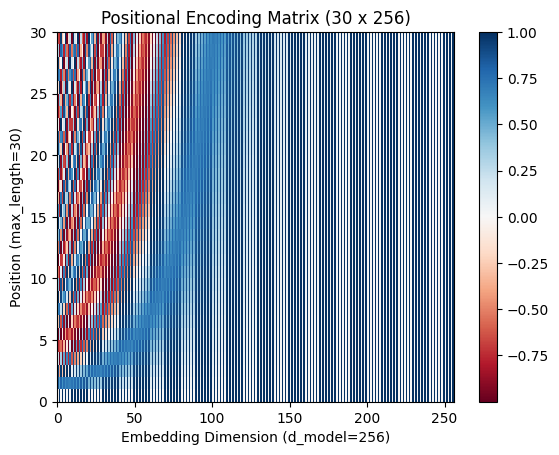

Positional Encoding Shape: (1, 30, 256)


In [7]:
# 포지셔널 인코딩 레이어 정의
max_length = 30    # 최대 문장 길이
d_model = 256     # 임베딩 차원

# 포지셔널 인코딩 객체 생성
positional_encoding = PositionalEncoding(max_length, d_model)

# 시각화
# plt.figure(figsize=(10, 8))
plt.pcolormesh(positional_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Embedding Dimension (d_model=256)')
plt.xlim((0, d_model))
plt.ylabel('Position (max_length=30)')
plt.title('Positional Encoding Matrix (30 x 256)')
plt.colorbar()
plt.show()

# 행렬 크기 확인
print("Positional Encoding Shape:", positional_encoding.pos_encoding.shape)